**Ануфриева Виктория, 5130901/10202**

### *Упражнение 7.2.*

Согласно методическому материалу, у нас есть метод для получения ДПФ за время, пропорциональное N^2, однако в данной работе нам необходимо попробовать использовть оптимизацию, которая позволят ускорить работу этого метода.

Более быстрый метод назван быстрым преобразованием Фурье (БПФ).

Он основан на лемме Дэниелсона-Ланцоша:

DFT(y)[n]=DFT(e)[n]+exp⁡((-2πin)⁄n)∙DFT(o)[n]

Где:

DFT(y)[n] – n-й элемент ДПФ от y,

e и o – массивы сигнала, содержащие соответственно четные и нечетные компоненты y.

Благодаря этой лемме был разработан следующий рекурсивный алгоритм:

	Разделим массив сигнала y на четные элементы e и нечетные элементы o.
	Вычислим DFT e и o, используя рекурсивный вызов.
	Вычислим DFT(y) для каждого значения n, используя лемму Дэниелсона-Ланцоша.

Создадим простой сигнал и вычислим его ДПФ, используя функцию numpy:


In [1]:
import numpy as np
import matplotlib.pyplot as plt
PI2 = 2 * np.pi
# %%
ys = [-0.5, 0.1, 0.7, -0.1]
hs = np.fft.fft(ys)
hs

array([ 0.2+0.j , -1.2-0.2j,  0.2+0.j , -1.2+0.2j])

Полученные значения будем использовать, как эталон для проверки корректности построения функции.

Сначала проверим лемму на корректность - создадим функцию, которая вместо рекурсивного вызова делит массив на две части, вычисляет их ДПФ (используя функцию numpy) и подставляет значения в лемму:


In [3]:
def fft_norec(ys):
    N = len(ys)
    He = np.fft.fft(ys[::2])
    Ho = np.fft.fft(ys[1::2])

    ns = np.arange(N)
    W = np.exp(-1j * PI2 * ns / N)

    return np.tile(He, 2) + W * np.tile(Ho, 2)

Нас интересует разница в выводе между этим методом и методом из numpy:

In [4]:
hs1 = fft_norec(ys)
np.sum(np.abs(hs - hs1))

0.0

Мы получили 0, значит, использование метода выше допустимо.

Теперь вместо того, чтоб использовать встроенную функцию, вызовем нашу функцию рекурсивно, согласно второму пункту алгоритма:

In [6]:
def my_fft(ys):
    N = len(ys)
    if N == 1:
        return ys

    He = my_fft(ys[::2])
    Ho = my_fft(ys[1::2])

    ns = np.arange(N)
    W = np.exp(-1j * PI2 * ns / N)

    return np.tile(He, 2) + W * np.tile(Ho, 2)

В код пришлось добавить проверку на длину массива (базовый случай), чтобы алгоритм не ушел в бесконечный цикл.

Вызовем получившуюся функцию и посмотрим на результат погрешности:


In [7]:
hs2 = my_fft(ys)
np.sum(np.abs(hs - hs2))

1.6653345369377348e-16

Выходное значение очень маленькое, что говорит о корректности рассчётов и погрешности вычислений в методе.

Но мы всё ещё не можем утверждать, что эта функция более быстрая.

Для подтверждения предположений проверим функцию из методических материалов на предмет сложности N^2:


In [9]:
def dft(ys):
    N = len(ys)
    ts = np.arange(N) / N
    freqs = np.arange(N)
    args = np.outer(ts, freqs)
    M = np.exp(1j * PI2 * args)
    amps = M.conj().transpose().dot(ys)
    return amps

hs3 = dft(ys)
np.sum(np.abs(hs - hs3))

5.864775846765962e-16

Также, нам необходима функция для замера скорости выполнения:

In [10]:
def run_speed_test(func, lengths, ys):
    bests = []
    print(func.__name__)
    for l in lengths:
        print(l)
        result = %timeit -r1 -o func(ys[:l])
        bests.append(result.best)

    return bests

И функция, которая будет генерировать массив ys заданной длинны в пределах от -1 до 1:

In [11]:
def generate_ys(max_length=2**5):
    return np.random.uniform(-1, 1, max_length)

Для создания выборок разной длинны (по степеням двойки) создадим массив lengths, и сгенерируем ys необходимой длинны:

In [12]:
max_length = 15
lengths = [2 ** i for i in range(5, max_length)]
ys = generate_ys(lengths[-1])

Теперь запустим speed_test для встроенного метода в numpy.

Результат представлени ниже:

In [13]:
fft_res = run_speed_test(np.fft.fft, lengths, ys)

fft
32
3.08 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 100000 loops each)
64
3.68 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 100000 loops each)
128
4.62 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 100000 loops each)
256
5.72 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 100000 loops each)
512
10.3 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 100000 loops each)
1024
19.9 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 10000 loops each)
2048
32.1 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 10000 loops each)
4096
62.8 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 10000 loops each)
8192
305 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 10000 loops each)
16384
441 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 1000 loops each)


Выполним этот же вызов для функции dft, которая по утверждению автора книги работает за время N^2:

In [14]:
dft_res = run_speed_test(dft, lengths, ys)

dft
32
81.2 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 10000 loops each)
64
432 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 1000 loops each)
128
1.47 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1000 loops each)
256
7.58 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)
512
48.8 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
1024
140 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
2048
295 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
4096
1.35 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
8192
5.85 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
16384
23.5 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


Аналогично измерим время работы созданной функции БПФ:

In [15]:
my_fft_res = run_speed_test(my_fft, lengths, ys)

my_fft
32
593 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 1000 loops each)
64
1.29 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1000 loops each)
128
2.67 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)
256
5.28 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)
512
15.6 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)
1024
34.8 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
2048
49.1 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
4096
87.4 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
8192
256 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
16384
402 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


Для более удобого сравнения результатов выведем их в виде графиков в логарифмической шкале и посчитаем их наклон.

Итоговый график выглядит так:

fft 0.8261135377510959
dft 1.9751480076555126
my_fft 1.05491461207471


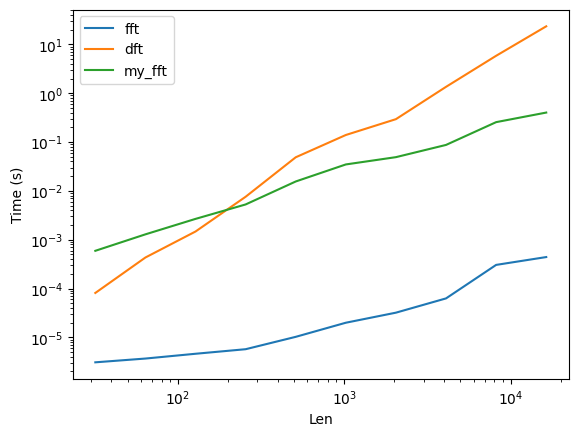

In [16]:
from scipy.stats import linregress

def plot_speed_test(lengths, ys, label):
    plt.plot(lengths, ys, label=label)
    x = np.log(lengths)
    y = np.log(ys)
    t = linregress(x,y)
    print(label, t[0])

plot_speed_test(lengths, fft_res, 'fft')
plot_speed_test(lengths, dft_res, 'dft')
plot_speed_test(lengths, my_fft_res, 'my_fft')

plt.legend()
plt.xlabel('Len')
plt.ylabel('Time (s)')
plt.xscale('log')
plt.yscale('log')

Из представленного графика мы видим, что быстрее всего работает встроенная функция - fft, и возрастает она достаточно медленно.

Быстрее всех возрастает функция dft, которую мы взяли из методических материалов, в начале она, нужно заметить, работает быстрее my_fft.

 Как и ожидалось, наша функция возрастает достаточно медленно.

Что касается наклона, наклон dft почти равен 2, что доказывает пропорцию N^2.

fft и my_fft не являются абсолютно прямыми, и их наклон примерно равен 1, что может говорить о логарифмической зависимости их скорости роста.
